This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Leonardo Rainbow

In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

Rainbow refers to the commercial [RAINBOW®5 APPLICATION SOFTWARE](https://www.leonardogermany.com/en/products/rainbow-5) which exports data in an XML flavour, which due to binary data blobs violates XML standard. Leonardo/Gematronik provided python code for implementing this reader in $\omega radlib$, which is very much appreciated.

The philosophy behind the $\omega radlib$ interface to Leonardos data model is very straightforward: $\omega radlib$ simply translates the complete xml file structure to *one* dictionary and returns this dictionary to the user. Thus, the potential complexity of the stored data is kept and it is left to the user how to proceed with this data. The keys of the output dictionary are strings that correspond to the "xml nodes" and "xml attributes". Each ``data`` key points to a Dataset (i.e. a numpy array of data). 

<div class="alert alert-warning">

**Note** <br>
    
For radar data in Rainbow5 format the [openradar community](https://openradarscience.org/) published [xradar](https://docs.openradarscience.org/projects/xradar/en/latest/) where xarray-based readers/writers are implemented. That particular code was ported from $\omega radlib$ to xradar. Please refer to xradar for enhancements for polar radar.    
    
From $\omega radlib$ version 1.19 `Rainbow5` reading code is imported from [xradar](https://github.com/openradar/xradar)-package whenever and wherever necessary.

Please read the more indepth notebook [rainbow_backend](../backends/rainbow_backend.ipynb).
    
</div>

#### Load Rainbow file

Such a file (typical ending: *.vol* or *.azi*) can be read by:

In [2]:
filename = wrl.util.get_wradlib_data_file("rainbow/2013070308340000dBuZ.azi")
rbdict = wrl.io.read_rainbow(filename)

#### Check Contents

In [3]:
# which keyswords can be used to access the content?
print(rbdict.keys())
# print the entire content including values of data and metadata
# (numpy arrays will not be entirely printed)
print(rbdict["volume"]["sensorinfo"])

dict_keys(['volume'])
{'@type': 'rainscanner', '@id': 'WUE', '@name': 'Wuestebach', 'lon': '6.330970', 'lat': '50.504900', 'alt': '0.000000', 'wavelen': '0.05', 'beamwidth': '1'}


#### Get azimuthal data

In [4]:
azi = rbdict["volume"]["scan"]["slice"]["slicedata"]["rayinfo"]["data"]
azidepth = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rayinfo"]["@depth"])
azirange = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rayinfo"]["@rays"])
azires = float(rbdict["volume"]["scan"]["slice"]["anglestep"])
azi = (azi * azirange / 2**azidepth) * azires

#### Create range array

In [5]:
stoprange = float(rbdict["volume"]["scan"]["slice"]["stoprange"])
rangestep = float(rbdict["volume"]["scan"]["slice"]["rangestep"])
r = np.arange(0, stoprange, rangestep)

#### Get reflectivity data

In [6]:
data = rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["data"]
datadepth = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["@depth"])
datamin = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["@min"])
datamax = float(rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["@max"])
data = datamin + data * (datamax - datamin) / 2**datadepth

#### Get annotation data

In [7]:
unit = rbdict["volume"]["scan"]["slice"]["slicedata"]["rawdata"]["@type"]
time = rbdict["volume"]["scan"]["slice"]["slicedata"]["@time"]
date = rbdict["volume"]["scan"]["slice"]["slicedata"]["@date"]
lon = rbdict["volume"]["sensorinfo"]["lon"]
lat = rbdict["volume"]["sensorinfo"]["lat"]
sensortype = rbdict["volume"]["sensorinfo"]["@type"]
sensorname = rbdict["volume"]["sensorinfo"]["@name"]

#### Convert to DataArray

In [8]:
da = wrl.georef.create_xarray_dataarray(data, r=r, az=azi).wrl.georef.georeference()

#### Plot data with annotation

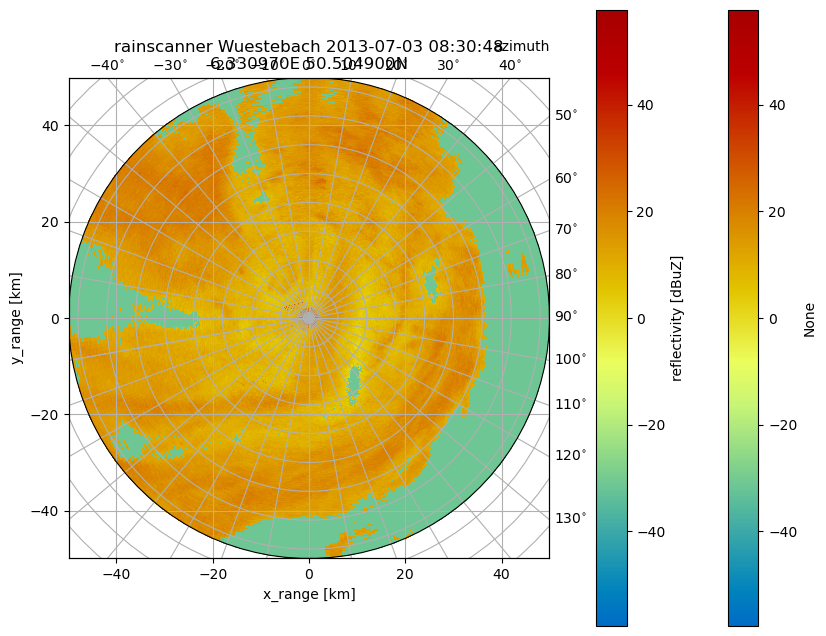

In [9]:
fig = plt.figure(figsize=(10, 8))
pm = da.wrl.vis.plot(fig=fig, crs="cg")

cgax = plt.gca()
title = "{0} {1} {2} {3}\n{4}E {5}N".format(
    sensortype, sensorname, date, time, lon, lat
)
caax = cgax.parasites[0]
paax = cgax.parasites[1]


t = plt.title(title, fontsize=12)
t.set_y(1.1)
cbar = plt.colorbar(pm, ax=[cgax, caax, paax], pad=0.075)
caax.set_xlabel("x_range [km]")
caax.set_ylabel("y_range [km]")
plt.text(1.0, 1.05, "azimuth", transform=caax.transAxes, va="bottom", ha="right")
cbar.set_label("reflectivity [" + unit + "]")